<a href="https://colab.research.google.com/github/sarth-04/DDOS/blob/main/Training_RNN_DDOS_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found label column with name: ' Label'


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9555 - loss: 0.2229 - val_accuracy: 0.9970 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9957 - loss: 0.0142 - val_accuracy: 0.9983 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9992 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9912 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9980 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0036
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9988 - loss: 0.0036 - v

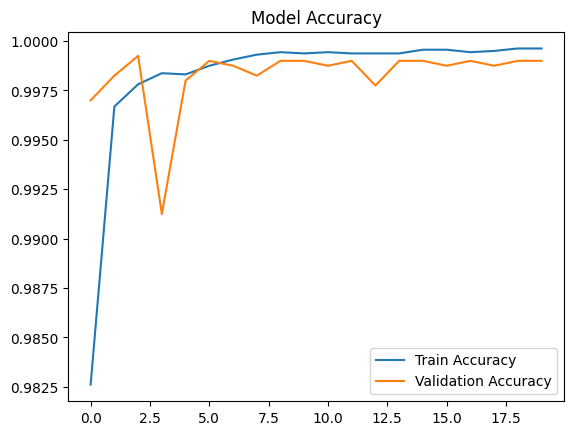

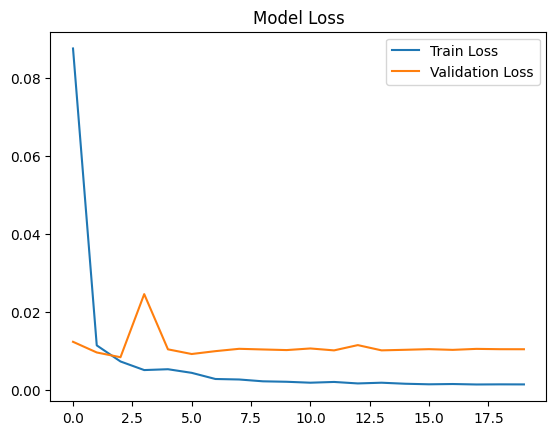

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. Load and Inspect Dataset
# ============================
data = pd.read_csv('/content/balanced_ddos_benign_dataset.csv')

# Handle missing values (if any)
data = data.dropna()

# 2. Encode Target Labels
# ========================
# Check if 'Label' column exists, if not, try variations or print columns
if 'Label' not in data.columns:
    # Possible variations of the column name
    possible_label_columns = ['label', ' Label', 'LABEL']
    for col in possible_label_columns:
        if col in data.columns:
            print(f"Found label column with name: '{col}'")
            data.rename(columns={col: 'Label'}, inplace=True)  # Rename to 'Label'
            break
    else:
        print("Label column not found. Here are the available columns:")
        print(data.columns)
        # Handle the case where the label column is not found (e.g., exit or raise an error)
        # raise KeyError("Label column not found in the dataset.")

label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])  # 0 for BENIGN, 1 for DDoS



# Drop non-numeric and irrelevant columns
non_numeric_columns = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
data = data.drop(columns=non_numeric_columns, errors='ignore')

# 3. Split Features and Labels
# ============================
X = data.drop(columns=['Label'])
y = data['Label']

X = X.replace([np.inf, -np.inf], np.nan)
data_cleaned = pd.concat([X, y], axis=1).dropna()
X = data_cleaned.drop(columns=['Label'])
y = data_cleaned['Label']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

# 4. Train-Test Split
# ====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert labels to categorical (for binary classification)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 5. Build the RNN Model
# =======================
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Train the Model with Learning Rate Scheduler
# ===============================================
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# 7. Evaluate the Model
# ======================
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# 8. Visualize Training Performance
# ==================================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


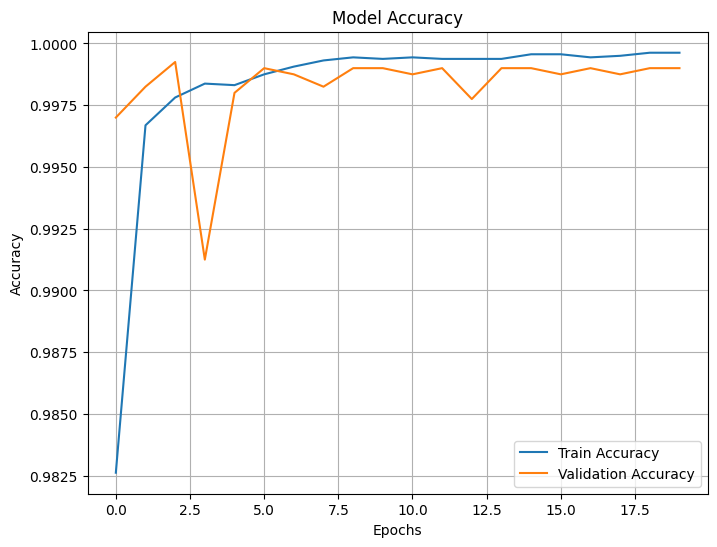

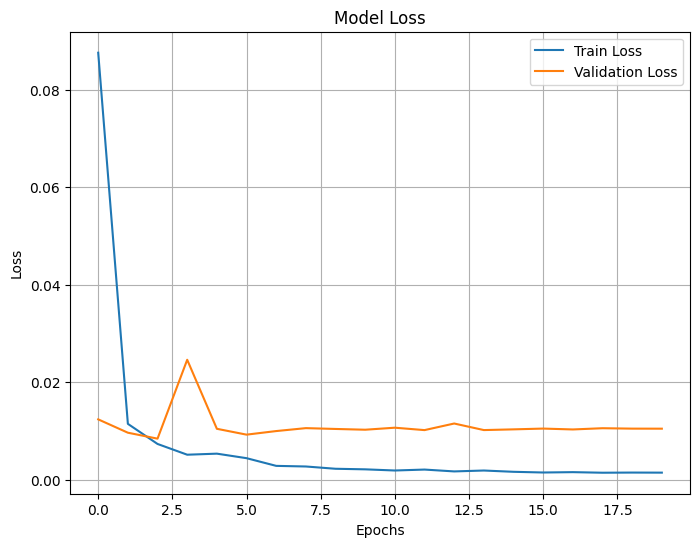

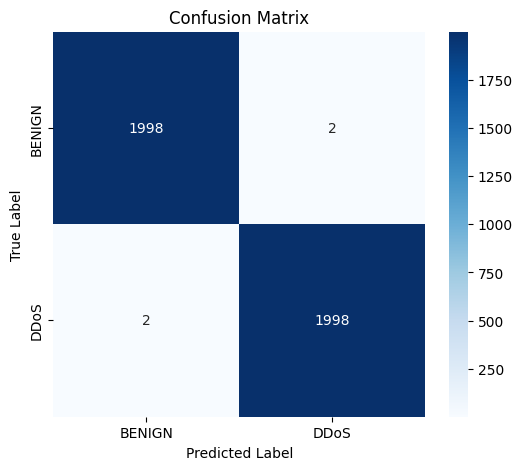

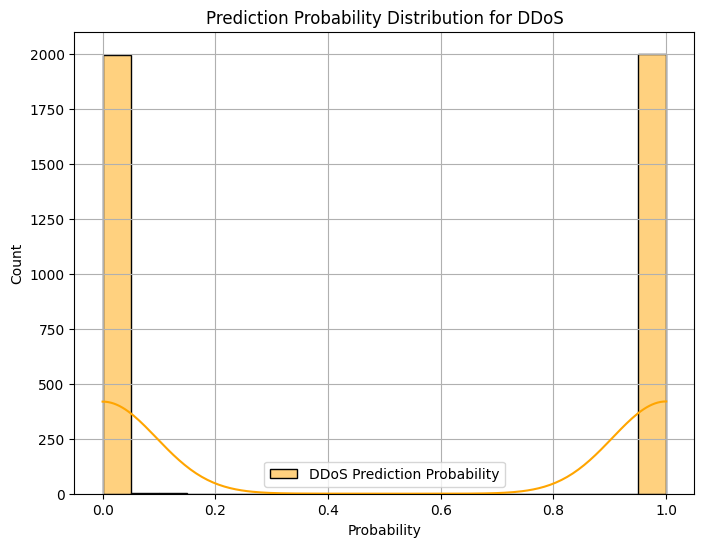

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

# 1. Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# 2. Plotting Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# 3. Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'DDoS'], yticklabels=['BENIGN', 'DDoS'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# 5. Prediction Probability Distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_pred[:, 1], bins=20, kde=True, color='orange', label='DDoS Prediction Probability')
plt.title('Prediction Probability Distribution for DDoS')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()
